In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='dark')

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

import os

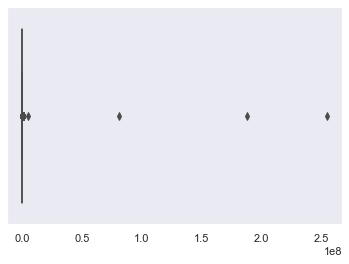

In [14]:
sns.boxplot(np.sort(train['SQUARE_FT']))

In [6]:
path = os.getcwd()

In [7]:
train = pd.read_csv(path + "\\Train.csv")
test = pd.read_csv(path+"\\Test.csv")
sample_sub = pd.read_csv(path+"\\sample_submission.csv")

In [322]:
train['TARGET(PRICE_IN_LACS)']=np.log1p(train['TARGET(PRICE_IN_LACS)'])

## Baseline Regression Model

Steps to make baseline Regression Model

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps, but we will go into it later.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a regression Model on train, check its results on validation set.

7. Predict for the test set.

8.  Save the submission as a csv file and submit the model on AV.

---
### 1. Concating Train and Test Set

In [323]:
df = pd.concat([train, test], axis = 0).reset_index(drop=True)
df.shape

(98171, 12)

### 2. Missing Values

In [324]:
df.isna().sum()

POSTED_BY                    0
UNDER_CONSTRUCTION           0
RERA                         0
BHK_NO.                      0
BHK_OR_RK                    0
SQUARE_FT                    0
READY_TO_MOVE                0
RESALE                       0
ADDRESS                      0
LONGITUDE                    0
LATITUDE                     0
TARGET(PRICE_IN_LACS)    68720
dtype: int64

### 3. Convert all categorical columns to number

#### Transformation

In [325]:
df['SQUARE_FT'] = np.log(df['SQUARE_FT'])

#### Changing Datatype

In [326]:
df['POSTED_BY'].replace( {'Owner' : 0, 'Builder' : 1, 'Dealer' : 2}, inplace = True)
df['BHK_OR_RK'].replace( {'BHK':1, 'RK': 0}, inplace = True)

df['BHK_NO.'].replace( {15:14, 16:15, 17:16, 18:17, 20:19, 31:19}, inplace= True)

In [327]:
df['POSTED_BY'] = df['POSTED_BY'].astype('uint8')
df['UNDER_CONSTRUCTION'] = df['UNDER_CONSTRUCTION'].astype('bool')
df['RERA'] = df['RERA'].astype('bool')
df['BHK_NO.'] = df['BHK_NO.'].astype('int8')
df['BHK_OR_RK'] = df['BHK_OR_RK'].astype('bool')
df['READY_TO_MOVE'] = df['READY_TO_MOVE'].astype('bool')
df['RESALE'] = df['RESALE'].astype('bool')

#### Encoding

In [328]:
df = pd.get_dummies(data = df, columns=['POSTED_BY'], drop_first=True)

In [329]:
df.rename(columns={"POSTED_BY_1": "POSTED_BY_One", "POSTED_BY_2": "POSTED_BY_Two"}, inplace = True)

### 4. Split the processed dataset back into train and test datasets

In [330]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)

In [331]:
target = 'TARGET(PRICE_IN_LACS)'

info = 'ADDRESS'

features = [col for col in df.columns if col not in ([target, info])]

### 5. Split the Train Set into Validation Set

In [332]:
trn, val = train_test_split(train_proc, test_size = 0.2, random_state = 1999)

##### Input for model
X_trn, X_val = trn[features], val[features]

##### Target column
y_trn, y_val = trn[target], val[target]

##### Features for test data that we will be predicting
X_test = test_proc[features]

### 6. Fit a Regression Model on train, check its result on validation set

**1. Linear Regression**

In [333]:
%%time

lr = LinearRegression()

lr.fit(X_trn, y_trn)

preds = lr.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.5881500947922242
Wall time: 21.9 ms


**2. Decision Tree**

In [334]:
%%time
dt = DecisionTreeRegressor(random_state = 1999, max_features = 0.9, max_leaf_nodes = 150)

dt.fit(X_trn, y_trn)

preds = dt.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.4236175420295884
Wall time: 59.8 ms


**3. Random Forest**

In [335]:
%%time
rf = RandomForestRegressor()

rf.fit(X_trn, y_trn)

preds = rf.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.342885502152445
Wall time: 6.19 s


### Boosting

**1. LGBM Regressor**

In [336]:
%%time
lgb = LGBMRegressor()

lgb.fit(X_trn, y_trn)

preds = lgb.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.3556984843225311
Wall time: 209 ms


**2. XGB Regressor**

In [337]:
%%time

xgb = XGBRegressor()

xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.3286331068402993
Wall time: 893 ms


**3. CATBoost Regressor**

In [338]:
%%time

cat = CatBoostRegressor(verbose = False)

cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.34394868179359556
Wall time: 3.89 s


---
# Validation Strategy

In [339]:
def cross_val(regressor, train, test, features):
    N_splits = 5
    
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    target_col = train[target]
    
    folds = StratifiedKFold(n_splits = N_splits, shuffle = True,random_state = 1999)
    stratified_target = pd.qcut( train[target], 10, labels=False, duplicates='drop')
    ""
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n================================Fold{index + 1}===================================')
        
        #### Train Set
        X_trn, y_trn = train[features].iloc[trn_idx], train[target].iloc[trn_idx]
        
        #### Validation Set
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
        
        #### Test Set
        X_test = test[features]
        
        #### Scaling Data ####
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)
        
        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        ############ Fitting #############
        _ = regressor.fit(X_trn, y_trn)
        
        ############ Predicting #############
        val_preds = np.abs(regressor.predict(X_val))
        test_preds = np.abs(regressor.predict(X_test))
        
        error = np.sqrt(mean_squared_error(y_val, val_preds))
        print(f'\n Root Log Mean Squared Error for Validation set is : {error}')
        
        oofs[val_idx] = val_preds
        preds += test_preds / N_splits
        
    total_error = np.sqrt(mean_squared_error(target_col, oofs))
    print(f'\n\Root Log Mean Squared Error for oofs is {total_error}')
    
    return oofs, preds

**1. Linear Regression**

In [340]:
%%time
lr_oofs, lr_preds = cross_val(lr, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.5885586652116632

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.5826603812909636

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.6053730723872894

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.588038635151981

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.6048064011883663

\Root Log Mean Squared Error for oofs is 0.5939612973537809
Wall time: 554 ms


**2. Decision Tree**

In [341]:
%%time
dt_oofs, dt_preds = cross_val(dt, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.41387435184558724

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.412862820771373

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.42561173830370996

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.42396688231601865

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.43692410498871653

\Root Log Mean Squared Error for oofs is 0.42273925091633097
Wall time: 730 ms


**3. Random Forest**

In [342]:
%%time
rf_oofs, rf_preds = cross_val(rf, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.34284011827363853

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.3326667599614402

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.35622215982841143

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.3488914496498778

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.3568979522457068

\Root Log Mean Squared Error for oofs is 0.3476209368130033
Wall time: 37.3 s


### Boosting

**1. LGBM**

In [343]:
%%time
lgb_oofs, lgb_preds = cross_val(lgb, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.3484723404361061

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.34731473398020823

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.37665775689720526

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.35566117991507873

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.3707447893860798

\Root Log Mean Squared Error for oofs is 0.3599657632797492
Wall time: 1.93 s


**2. XGBoost**

In [344]:
%%time
xgb_oofs, xgb_preds = cross_val(xgb, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.32182266646647306

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.3227833427708908

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.3386788388475621

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.3338466854834651

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.3574092376316847

\Root Log Mean Squared Error for oofs is 0.335158397169678
Wall time: 5.41 s


In [345]:
%%time
cat_oofs, cat_preds = cross_val(cat, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.3371271411207247

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.3369337548320258

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.35828892883218955

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.3497516368129221

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.35961839663888273

\Root Log Mean Squared Error for oofs is 0.3484825096937802
Wall time: 18.4 s


---
# Feature Engineering

### 1. Extracting Features

In [346]:
df['City'] = df['ADDRESS'].apply(lambda x: x.split(',')[-1])

In [347]:
df['Address'] = df['ADDRESS'].apply(lambda x: x.split(',')[0])

In [348]:
df.drop('ADDRESS', axis = 1, inplace=True)

### 2. Grouping Features

In [349]:
df['mean_sqft_per_bhkno'] = df.groupby('BHK_NO.')['SQUARE_FT'].transform('median')
df['min_sqft_per_bhkno'] = df.groupby('BHK_NO.')['SQUARE_FT'].transform('min')
df['max_sqft_per_bhkno'] = df.groupby('BHK_NO.')['SQUARE_FT'].transform('max')

In [350]:
df['mean_sqft_per_location'] = df.groupby('LONGITUDE')['SQUARE_FT'].transform('median')
df['min_sqft_per_location'] = df.groupby('LONGITUDE')['SQUARE_FT'].transform('min')
df['max_sqft_per_location'] = df.groupby('LONGITUDE')['SQUARE_FT'].transform('max')

In [351]:
df['mean_sqft_per_city'] = df.groupby('City')['SQUARE_FT'].transform('median')
df['min_sqft_per_city'] = df.groupby('City')['SQUARE_FT'].transform('min')
df['max_sqft_per_city'] = df.groupby('City')['SQUARE_FT'].transform('max')

In [352]:
df['mean_sqft_per_address'] = df.groupby('Address')['SQUARE_FT'].transform('median')
df['min_sqft_per_address'] = df.groupby('Address')['SQUARE_FT'].transform('min')
df['max_sqft_per_address'] = df.groupby('Address')['SQUARE_FT'].transform('max')

#### Square feet per room

In [353]:
df['sqft_per_room'] = df.apply(lambda x: x['SQUARE_FT']/x['BHK_NO.'], axis = 1)

#### Price per Square feet in city

In [354]:
train['City'] = train['ADDRESS'].apply(lambda x: x.split(',')[-1])
test['City'] = test['ADDRESS'].apply(lambda x: x.split(',')[-1])

In [355]:
train['City'].nunique(),test['City'].nunique()

(256, 293)

In [356]:
a = np.array(train['City'].unique())
b = np.array(test['City'].unique())

In [373]:
city_replace = {'Alappuzha' : 'Kochi','Amreli' : 'Rajkot','Azamgarh' : 'Varanasi','Barmer' : 'Jodhpur','Barnala' : 'Ludhiana',
                'Bellary': 'Anantapur','Bhilwara' : 'Ajmer','Bhusawal' : 'Dhule','Birbhum' : 'Bardhaman','Bulandshahr' : 'Hapur',
                'Burhanpur' : 'Jalgaon','Chittorgarh' : 'Udaipur','Contai' : 'Kharagpur','Dewas' : 'Indore','Dhar' : 'Indore',
                'Dhenkanal' : 'Cuttack','Dindigul' : 'Madurai','Firozabad' : 'Agra','Gangtok' : 'Darjeeling','Gorakhpur' : 'Varanasi','Gudivada' : 'Vijayawada',
                'Jaisalmer' : 'Jaipur','Jalpaiguri' : 'Siliguri','Jhajjar' : 'Rohtak','Jorhat' : 'Nagaon','Kaithal' : 'Patiala','Karimnagar' : 'Warangal',
                'Karur' : 'Salem','Katni' : 'Jabalpur','Kaushambi' : 'Satna','Khandwa' : 'Jalgaon','Kolar' : 'Vellore','Malegaon' : 'Dhule',
                'Mancherial' : 'Warangal','Mandsaur' : 'Ujjain','Morena' : 'Gwalior','Namakkal' : 'Salem','Palani' : 'Madurai','Panchmahal' : 'Godhra',
                'Patan' : 'Gandhinagar','Pathankot' : 'Jammu','Pollachi' : 'Coimbatore','Purulia' : 'Dhanbad','Raebareli' : 'Lucknow','Rajsamand' : 'Udaipur',
                'Ramgarh' : 'Nainital','Rampur' : 'Moradabad','Ratlam' : 'Ujjain','Rupnagar' : 'Chandigarh','Shimoga' : 'Mangalore','Sirsa' : 'Patiala',
                'Sivasagar' : 'Dibrugarh','Tezpur' : 'Guwahati','Theni' : 'Madurai','Thiruvarur' : 'Thanjavur','Tiruchengode' : 'Erode',
                'Tumkur' : 'Bangalore','Viramgam' : 'Gandhinagar','Wayanad' : 'Ooty'}

In [374]:
replace_list = list(np.setdiff1d(b,a))

In [375]:
sq_sum = df.groupby('City')['SQUARE_FT'].sum().to_dict()
price_sum = df.groupby('City')['TARGET(PRICE_IN_LACS)'].sum().to_dict()

In [376]:
df['sq_sum'] = df['City'].apply(lambda x: sq_sum[city_replace[x]] if x in replace_list else sq_sum[x])
df['price_sum'] = df['City'].apply(lambda x: price_sum[city_replace[x]] if x in replace_list else price_sum[x])
df['price_per_sqft_in_city'] = df['price_sum']/df['sq_sum']

df.drop(['sq_sum'], axis = 1, inplace=True)
df.drop(['price_sum'], axis = 1, inplace=True)

In [ ]:
#### Min, Max, Median 

In [318]:
median_price_per_city_dict = train.groupby('City')['TARGET(PRICE_IN_LACS)'].median().to_dict()
min_price_per_city_dict = train.groupby('City')['TARGET(PRICE_IN_LACS)'].min().to_dict()
max_price_per_city_dict = train.groupby('City')['TARGET(PRICE_IN_LACS)'].max().to_dict()

In [378]:
df['med_price_per_city'] = df['City'].apply(lambda x : median_price_per_city_dict[ city_replace[x]] if x in replace_list else median_price_per_city_dict[x])
df['min_price_per_city'] = df['City'].apply(lambda x : min_price_per_city_dict[ city_replace[x]] if x in replace_list else min_price_per_city_dict[x])
df['max_price_per_city'] = df['City'].apply(lambda x : max_price_per_city_dict[ city_replace[x]] if x in replace_list else max_price_per_city_dict[x])

---
# Preprocessing

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98171 entries, 0 to 98170
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNDER_CONSTRUCTION      98171 non-null  bool   
 1   RERA                    98171 non-null  bool   
 2   BHK_NO.                 98171 non-null  int8   
 3   BHK_OR_RK               98171 non-null  bool   
 4   SQUARE_FT               98171 non-null  float32
 5   READY_TO_MOVE           98171 non-null  bool   
 6   RESALE                  98171 non-null  bool   
 7   LONGITUDE               98171 non-null  float32
 8   LATITUDE                98171 non-null  float32
 9   TARGET(PRICE_IN_LACS)   29451 non-null  float64
 10  POSTED_BY_One           98171 non-null  uint8  
 11  POSTED_BY_Two           98171 non-null  uint8  
 12  City                    98171 non-null  int32  
 13  Address                 98171 non-null  int32  
 14  mean_sqft_per_bhkno     98171 non-null

In [383]:
col_ls = ['SQUARE_FT', 'LONGITUDE', 'LATITUDE',
       'mean_sqft_per_bhkno', 'min_sqft_per_bhkno', 'max_sqft_per_bhkno',
       'mean_sqft_per_location', 'min_sqft_per_location',
       'max_sqft_per_location', 'mean_sqft_per_city', 'min_sqft_per_city',
       'max_sqft_per_city', 'mean_sqft_per_address', 'min_sqft_per_address',
       'max_sqft_per_address', 'sqft_per_room', 'price_per_sqft_in_city',
       'med_price_per_city', 'min_price_per_city', 'max_price_per_city']


for col in col_ls:
    df[col] = df[col].astype('float32')

In [386]:
df[[ 'City', 'Address']] = df[[ 'City', 'Address']].apply(le.fit_transform)

---
## Splitting

In [388]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)

In [389]:
target = 'TARGET(PRICE_IN_LACS)'


features = [col for col in df.columns if col not in ([target])]

In [390]:
trn, val = train_test_split(train_proc, test_size = 0.2, random_state = 1999)

##### Input for model
X_trn, X_val = trn[features], val[features]

##### Target column
y_trn, y_val = trn[target], val[target]

##### Features for test data that we will be predicting
X_test = test_proc[features]



In [391]:
%%time

dt = DecisionTreeRegressor()

dt.fit(X_trn, y_trn)

preds = dt.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.4021295145662708
Wall time: 349 ms


In [392]:
%%time

rf = RandomForestRegressor()

rf.fit(X_trn, y_trn)

preds = rf.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.28642964347876565
Wall time: 18.8 s


In [834]:
%%time
lgb = LGBMRegressor()

lgb.fit(X_trn, y_trn)

preds = lgb.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')


mean_squared_log_error is : 0.3088388225088558
Wall time: 339 ms


In [393]:
%%time

xgb = XGBRegressor()

xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.29969891827075984
Wall time: 1.34 s


In [394]:
%%time

cat = CatBoostRegressor(verbose = False)

cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.2859229158045891
Wall time: 4.57 s


---
# Cross Val

In [837]:
%%time
rf_oofs, rf_preds = cross_val(rf, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.28109878401683447

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.3144883606594597

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.29161293421758777

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.31927025627794464

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.30642988378073327

\Root Log Mean Squared Error for oofs is 0.3029152243815559
Wall time: 1min 27s


In [838]:
%%time
lgb_oofs, lgb_preds = cross_val(lgb, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.3092731366054101

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.3259194776669862

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.30053182891492913

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.3130088626323364

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.3214032132826307

\Root Log Mean Squared Error for oofs is 0.3141549986909707
Wall time: 3.65 s


In [395]:
%%time
xgb_oofs, xgb_preds = cross_val(xgb, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.28086419797355705

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.28763420869344763

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.29248491873614024

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.28324617440006605

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.3043479772967508

\Root Log Mean Squared Error for oofs is 0.28983470489953783
Wall time: 8.61 s


In [396]:
%%time
cat_oofs, cat_preds = cross_val(cat, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.277304751673701

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.2795872801212191

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.29392066212069673

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.28175516256125077

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.2926742303100897

\Root Log Mean Squared Error for oofs is 0.2851314635295498
Wall time: 23.9 s


---
# Hyperparameter Tuning

## 1. Random Forest

In [397]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 500, 1000)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 7)
    model = RandomForestRegressor( 
        max_depth=max_depth,
        n_estimators = n_estimators,
        min_samples_split = min_samples_split,
        random_state=0,
        n_jobs = -1
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = mean_squared_error(y_val,preds)
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=30)

rf_params = study.best_params
rf_params['random_state'] = 0
rf = RandomForestRegressor(**rf_params)
rf.fit(X_trn, y_trn)
preds = rf.predict(X_val)
print('Optimized LightGBM roc_auc_score', mean_squared_error(y_val, preds))

[I 2020-10-16 15:59:45,747] A new study created in memory with name: no-name-6e51224a-c944-47dc-a5ab-58e18dd70a73
[I 2020-10-16 15:59:56,669] Trial 0 finished with value: 0.08533488738400027 and parameters: {'max_depth': 14, 'n_estimators': 547, 'min_samples_split': 7}. Best is trial 0 with value: 0.08533488738400027.
[I 2020-10-16 16:00:00,398] Trial 1 finished with value: 0.36532060981365255 and parameters: {'max_depth': 2, 'n_estimators': 823, 'min_samples_split': 5}. Best is trial 0 with value: 0.08533488738400027.
[I 2020-10-16 16:00:08,613] Trial 2 finished with value: 0.162094415303273 and parameters: {'max_depth': 5, 'n_estimators': 859, 'min_samples_split': 3}. Best is trial 0 with value: 0.08533488738400027.
[I 2020-10-16 16:00:34,194] Trial 3 finished with value: 0.08192605875200858 and parameters: {'max_depth': 21, 'n_estimators': 777, 'min_samples_split': 4}. Best is trial 3 with value: 0.08192605875200858.
[I 2020-10-16 16:00:42,578] Trial 4 finished with value: 0.1388195

Optimized LightGBM roc_auc_score 0.08172235600432984


## 2. LGBM

In [398]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 1000)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 1000)
    model = LGBMRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        colsample_bytree = colsample_bytree,
        min_child_samples=min_child_samples,
        random_state=1999,
        n_jobs = -1,
        n_estimators = 1500
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

lgb_params = study.best_params
lgb_params['random_state'] = 1999
lgb = LGBMRegressor(**lgb_params)
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
print('Optimized LightGBM RLMSE', np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-16 16:11:05,078] A new study created in memory with name: no-name-3c9d7cf8-0b88-4d95-812d-fabab4098a26
[I 2020-10-16 16:11:11,161] Trial 0 finished with value: 0.311314171871366 and parameters: {'max_depth': 14, 'learning_rate': 0.6335601564025165, 'num_leaves': 3266, 'colsample_bytree': 0.5822107008573151, 'min_child_samples': 198, 'reg_alpha': 360, 'reg_lambda': 10}. Best is trial 0 with value: 0.311314171871366.
[I 2020-10-16 16:11:34,196] Trial 1 finished with value: 0.3276713231655326 and parameters: {'max_depth': 21, 'learning_rate': 0.6813047017599905, 'num_leaves': 3470, 'colsample_bytree': 0.40675321506062223, 'min_child_samples': 42, 'reg_alpha': 88, 'reg_lambda': 175}. Best is trial 0 with value: 0.311314171871366.
[I 2020-10-16 16:12:02,229] Trial 2 finished with value: 0.31707755478589345 and parameters: {'max_depth': 26, 'learning_rate': 0.4535063164907468, 'num_leaves': 539, 'colsample_bytree': 0.15682884655830956, 'min_child_samples': 12, 'reg_alpha': 917, 'r

Optimized LightGBM RLMSE 0.37872990112480437


In [399]:

#lgb = LGBMRegressor(random_state=1999,learning_rate=0.09, colsample_bytree=0.9, num_leaves=180, max_depth=30, 
#                    min_child_samples=3, reg_alpha=0.5)

lgb.fit(X_trn, y_trn)

preds = lgb.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.37872990112480437


In [400]:

lgb = LGBMRegressor(random_state=1999,learning_rate=0.09, colsample_bytree=0.9, num_leaves=180, max_depth=30, 
                    min_child_samples=3, reg_alpha=0.5)

lgb.fit(X_trn, y_trn)

preds = lgb.predict(X_val)
preds = np.abs(preds)

error = np.sqrt(mean_squared_error(y_val, preds))

print(f'mean_squared_log_error is : {error}')

mean_squared_log_error is : 0.27747071855979877


### 3. XGB

In [401]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 400, 1500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9)
    #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = XGBRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        colsample_bytree = colsample_bytree,
        #num_leaves=num_leaves, 
        #min_child_samples=min_child_samples,
        random_state=0,
        n_jobs = -1
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=30)

xgb_params = study.best_params
xgb_params['random_state'] = 0
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-16 16:17:25,913] A new study created in memory with name: no-name-50f62c9e-34ab-4817-818b-7731b6080ef8
[I 2020-10-16 16:17:33,204] Trial 0 finished with value: 0.33100932488429874 and parameters: {'max_depth': 14, 'n_estimators': 959, 'learning_rate': 0.7436704297351775, 'colsample_bytree': 0.5822107008573151, 'reg_alpha': 4, 'reg_lambda': 8}. Best is trial 0 with value: 0.33100932488429874.
[I 2020-10-16 16:17:45,470] Trial 1 finished with value: 0.2986666401863318 and parameters: {'max_depth': 11, 'n_estimators': 677, 'learning_rate': 0.4459435365634299, 'colsample_bytree': 0.3380276852355778, 'reg_alpha': 9, 'reg_lambda': 9}. Best is trial 1 with value: 0.2986666401863318.
[I 2020-10-16 16:17:53,409] Trial 2 finished with value: 0.31551293148374154 and parameters: {'max_depth': 14, 'n_estimators': 714, 'learning_rate': 0.5298986055892149, 'colsample_bytree': 0.7497349830203945, 'reg_alpha': 9, 'reg_lambda': 2}. Best is trial 1 with value: 0.2986666401863318.
[I 2020-10-16

Optimized LightGBM roc_auc_score 0.27888446370153225


### 4. CATBoost

In [951]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 1, 16)
    n_estimators = trial.suggest_int("n_estimators", 500, 1500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    rsm = trial.suggest_uniform('rsm', 0.1, 0.99)
    #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = CatBoostRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        rsm = rsm,
        reg_lambda=reg_lambda,
        #num_leaves=num_leaves, 
        #min_child_samples=min_child_samples,
        random_state=0,
        verbose=False
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

cat_params = study.best_params
cat_params['random_state'] = 0
cat = CatBoostRegressor(**cat_params)
cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
print('Optimized LightGBM roc_auc_score',np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-15 21:42:25,993] A new study created in memory with name: no-name-bd28f0b7-6554-4894-a8c9-7e1d76a7df4b
[I 2020-10-15 21:45:55,841] Trial 0 finished with value: 0.33849508057876143 and parameters: {'max_depth': 13, 'n_estimators': 1059, 'learning_rate': 0.7436704297351775, 'rsm': 0.636459404703763, 'reg_lambda': 4}. Best is trial 0 with value: 0.33849508057876143.
[I 2020-10-15 21:46:02,305] Trial 1 finished with value: 0.2983576927902047 and parameters: {'max_depth': 8, 'n_estimators': 509, 'learning_rate': 0.6612073271073751, 'rsm': 0.44209971949050286, 'reg_lambda': 8}. Best is trial 1 with value: 0.2983576927902047.
[I 2020-10-15 21:46:11,856] Trial 2 finished with value: 0.32412434060714446 and parameters: {'max_depth': 7, 'n_estimators': 972, 'learning_rate': 0.9672964844509263, 'rsm': 0.4412629517549421, 'reg_lambda': 7}. Best is trial 1 with value: 0.2983576927902047.
[I 2020-10-15 21:46:19,557] Trial 3 finished with value: 0.29763699647308844 and parameters: {'max_de

KeyboardInterrupt: 

---
# Models

In [735]:
#params = {'max_depth': 22, 'n_estimators': 615, 'min_samples_split': 2}
#rf = RandomForestRegressor(**params)

In [736]:
#lgb = LGBMRegressor(colsample_bytree=0.39051197438089075,
#              learning_rate=0.12999284224611848, max_depth=19,
#              min_child_samples=61, n_estimators=1126, num_leaves=2916,
#              random_state=0, reg_alpha=731, reg_lambda=822)

In [738]:
#xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=0.43490150687901447, gamma=0,
#             gpu_id=-1, importance_type='gain', interaction_constraints='',
#             learning_rate=0.10792380545506054, max_delta_step=0, max_depth=7,
#             min_child_weight=1, monotone_constraints='()',
#             n_estimators=860, n_jobs=0, num_parallel_tree=1, random_state=0,
#             reg_alpha=5, reg_lambda=3, scale_pos_weight=1, subsample=1,
#             tree_method='exact', validate_parameters=1, verbosity=None)

In [402]:
params = {'learning_rate': 0.1837890419227305,
 'rsm': 0.8684840841795957,
 'loss_function': 'RMSE',
 'max_depth': 10,
 'n_estimators': 697,
 'random_state': 0,
 'reg_lambda': 6}

cat = CatBoostRegressor(**params, verbose = False)

---
# Final Predictions

In [403]:
%%time
rf_oofs, rf_preds = cross_val(rf, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.27739849896447344

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.28052626489094407

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.29191056509650576

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.28693269703376184

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.29693193604286633

\Root Log Mean Squared Error for oofs is 0.2868291248833282
Wall time: 9min 27s


In [439]:
%%time
lgb_oofs, lgb_preds = cross_val(lgb, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.26837162674198045

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.27206808745422234

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.28608102831096577

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.27591642503022734

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.28353553125801134

\Root Log Mean Squared Error for oofs is 0.27727537765126503
Wall time: 11.9 s


In [405]:
%%time
xgb_oofs, xgb_preds = cross_val(xgb, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.26262555958805806

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.26714782867344505

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.28540265885150495

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.26887536577949295

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.2787607601767787

\Root Log Mean Squared Error for oofs is 0.2726886259990918
Wall time: 51.4 s


In [406]:
%%time
cat_oofs, cat_preds = cross_val(cat, train_proc, test_proc, features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.2667283862060725

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.2728797905968799

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.2880058529044395

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.2784725201878774

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.28284110658757794

\Root Log Mean Squared Error for oofs is 0.2778847919338759
Wall time: 2min 43s


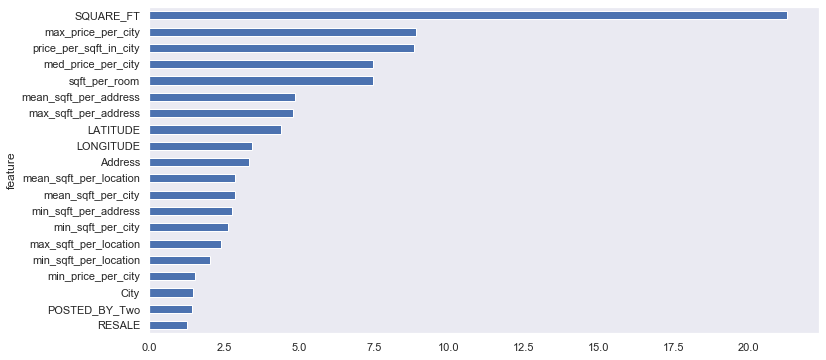

In [462]:
feature_importances = pd.DataFrame()
fold_importance = pd.DataFrame({'feature': features, 'importance': cat.feature_importances_})
feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

feature_importances = feature_importances.reset_index(drop = True)
fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
fi.plot(kind = 'barh', figsize=(12, 6))

---
# Ensembling

In [424]:
train_new = train_proc[[target, 'RERA']].copy()
test_new = test_proc[[target, 'RERA']].copy()

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cat_oofs
test_new['cb'] = cat_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

train_new['rf'] = rf_oofs
test_new['rf'] = rf_preds

ens_features = [c for c in train_new.columns if c not in [target, 'RERA']]

In [425]:
from sklearn.linear_model import Ridge

In [426]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

ens_linear_oofs, ens_linear_preds = cross_val(clf, train_new, test_new, ens_features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.25862980768505894

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.2623160854737572

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.27919487139993765

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.2660264646672368

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.2739672684084226

\Root Log Mean Squared Error for oofs is 0.2681328687457224


In [427]:
sample_sub['TARGET(PRICE_IN_LACS)']=np.abs((np.exp(ens_linear_preds)-1))
sample_sub.to_csv(path + '\\Ensemble.csv', index = False)

In [428]:
from sklearn.linear_model import LinearRegression
clf = Ridge()

ens_ridge_oofs, ens_ridge_preds = cross_val(clf, train_new, test_new, ens_features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.2586297253819578

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.26231590277962424

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.2791890245691495

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.2660299300089645

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.2739662025192611

\Root Log Mean Squared Error for oofs is 0.26813206936138057


In [429]:
from sklearn.linear_model import LinearRegression
clf = LGBMRegressor(max_depth=4, random_state=1999, colsample_bytree=0.7, min_child_samples=15)

ens_lgb_oofs, ens_lgb_preds = cross_val(clf, train_new, test_new, ens_features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.2624845263327296

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.2660635211670052

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.28395610821936557

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.26912419917621605

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.2764661353647834

\Root Log Mean Squared Error for oofs is 0.27172762668105344


---
# Stacking

In [430]:
train_new['lgb_ens'] = ens_lgb_oofs
test_new['lgb_ens'] = ens_lgb_preds

train_new['linear_ens'] = ens_linear_oofs
test_new['linear_ens'] = ens_linear_preds

train_new['ridge_ens'] = ens_ridge_oofs
test_new['ridge_ens'] = ens_ridge_preds

ens_features = [c for c in train_new.columns if c not in [target, 'RERA']]

In [437]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()


stack_linear_oofs, stack_linear_preds = cross_val(clf, train_new, test_new, ens_features)


================================Fold1===================================

 Root Log Mean Squared Error for Validation set is : 0.25844741905108737

================================Fold2===================================

 Root Log Mean Squared Error for Validation set is : 0.26206260117980895

================================Fold3===================================

 Root Log Mean Squared Error for Validation set is : 0.27858773166807427

================================Fold4===================================

 Root Log Mean Squared Error for Validation set is : 0.2655023518773141

================================Fold5===================================

 Root Log Mean Squared Error for Validation set is : 0.27325484404232964

\Root Log Mean Squared Error for oofs is 0.2676721443262248


In [432]:
sample_sub['TARGET(PRICE_IN_LACS)']=np.abs((np.exp(stack_linear_preds)-1))
sample_sub.to_csv(path + '\\Stacking.csv', index = False)